In [1]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
import model_explain.shap as meshap

from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

In [3]:
raw_data = pd.read_csv(os.path.join(root_path, "Covid-19 Twitter Dataset (Aug-Sep 2020).csv"))

In [4]:
raw_data.head(3)

,id,created_at,source,original_text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,clean_tweet,compound,neg,neu,pos,sentiment
0,1.300000e+18,Thu Aug 20 08:20:55 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @RobertAlai: 91-year-old Ex-Vice President ...,en,0.0,100.0,kvn_kegan,NaN,RobertAlai,"Nairobi, Kenya",year old ex vice presid moodi awori land inter...,0.0000,0.0,1.000,0.000,neu
1,1.300000e+18,Thu Aug 20 08:20:54 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @cnnphilippines: BREAKING: The Department o...,en,0.0,38.0,puTOPinamo,NaN,cnnphilippines,NaN,break depart health report peopl caught covid1...,0.0000,0.0,1.000,0.000,neu
2,1.300000e+18,Thu Aug 20 08:20:53 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @latestly: #SidharthShukla Helps Out Fan Wh...,en,0.0,0.0,DevSidheart,"SidharthShukla, Covid_19",latestly,Sidheart,help fan request help arrang bed posit father ...,0.7717,0.0,0.476,0.524,pos


In [5]:
data = raw_data[raw_data.original_text.isnull()==False]
data = data.drop_duplicates()
len(data)

242736

In [6]:
data.head(3)

,id,created_at,source,original_text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,clean_tweet,compound,neg,neu,pos,sentiment
0,1.300000e+18,Thu Aug 20 08:20:55 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @RobertAlai: 91-year-old Ex-Vice President ...,en,0.0,100.0,kvn_kegan,NaN,RobertAlai,"Nairobi, Kenya",year old ex vice presid moodi awori land inter...,0.0000,0.0,1.000,0.000,neu
1,1.300000e+18,Thu Aug 20 08:20:54 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @cnnphilippines: BREAKING: The Department o...,en,0.0,38.0,puTOPinamo,NaN,cnnphilippines,NaN,break depart health report peopl caught covid1...,0.0000,0.0,1.000,0.000,neu
2,1.300000e+18,Thu Aug 20 08:20:53 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @latestly: #SidharthShukla Helps Out Fan Wh...,en,0.0,0.0,DevSidheart,"SidharthShukla, Covid_19",latestly,Sidheart,help fan request help arrang bed posit father ...,0.7717,0.0,0.476,0.524,pos


If there is no clean_tweet, use the textClean.pipeline to preprocess the data. Use textClean.get_hashtag to generate hashtag.

In [124]:
# data['clean_tweet'] = textClean.pipeline(data['original_text'].to_list(), multi_gram = [1], 
#                                        remove_pattern = ['http','@','#'],
#                                        lower_case=True, deacc=False, encoding='utf8',
#                                        errors='strict', stem_lemma = 'stem', tag_drop = [''], 
#                                        nltk_stop=True, stop_word_list=['rt'], 
#                                        check_numbers=True, word_length=2, remove_consecutives=True)

In [16]:
# preprocessed_text = textClean.pipeline(data['original_text'][0:40].to_list(), multi_gram = [1], 
#                                        remove_pattern = ['http','@','#'],
#                                        lower_case=True, deacc=False, encoding='utf8',
#                                        errors='strict', stem_lemma = 'stem', tag_drop = [''], 
#                                        nltk_stop=True, stop_word_list=['rt'], 
#                                        check_numbers=True, word_length=2, remove_consecutives=True)
# preprocessed_text = [' '.join(i) for i in preprocessed_text]
# data['hashtag'] = data.clean_tweet.apply(lambda x: textClean.get_hashtag(x)) 

In [8]:
i = 3
print(data.original_text[i])
print("-----------")
print(data.clean_tweet[i])

Lending Club loan originations down 90% ... but hey, we're now a bank

https://t.co/tfCsMigObT
-----------
lend club loan origin hey bank


## Vader
Apply vader and generate neg, neu, pos and compound. This dataset already have these columns, this analysis can be done in the future task. Reference: https://predictivehacks.com/how-to-run-sentiment-analysis-in-python-using-vader/

In [93]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import twitter_samples

In [97]:
vader_analyzer = SentimentIntensityAnalyzer()
vader_analyzer.polarity_scores(data.clean_tweet[0])
# data['neg'] = data['clean_tweet'].apply(lambda x: vader_analyzer.polarity_scores(x)['neg'])
# data['neu'] = data['clean_tweet'].apply(lambda x: vader_analyzer.polarity_scores(x)['neu'])
# data['pos'] = data['clean_tweet'].apply(lambda x: vader_analyzer.polarity_scores(x)['pos'])
# data['compound'] = data['clean_tweet'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

## Explore Data

In [34]:
pos_tweet = list(x.split() for x in data[data['sentiment']=='pos']['clean_tweet'])
neg_tweet = list(x.split() for x in data[data['sentiment']=='neg']['clean_tweet'])
# neu_tweet = list(x.split() for x in data[data['sentiment']=='neu']['clean_tweet'])

In [35]:
postop10tfidf = tfidf.get_top_n_tfidf_bow(pos_tweet, top_n_tokens = 30)
negtop10tfidf = tfidf.get_top_n_tfidf_bow(neg_tweet, top_n_tokens = 30)
# neutop10tfidf = tfidf.get_top_n_tfidf_bow(neu_tweet, top_n_tokens = 30)
print('top 30 negative review tfidf', negtop10tfidf)
print('top 30 positive review tfidf', postop10tfidf)
# print('top 30 neutual review tfidf', neutop10tfidf)

top 30 negative review tfidf ['flu', 'shocker', 'shame', 'shake', 'see', 'scream', 'bullshit', 'scare', 'cancel', 'protest', 'prison', 'coward', 'odd', 'danger', 'dead', 'death', 'murder', 'shit', 'sick', 'die', 'blame', 'war', 'villain', 'victim', 'tragic', 'threat', 'terrorist', 'bad', 'suspect', 'suffer']
top 30 positive review tfidf ['TRUE', 'sure', 'join', 'joke', 'thank', 'dream', 'protect', 'god', 'top', 'prevent', 'pray', 'trust', 'truth', 'dear', 'like', 'play', 'cute', 'credit', 'lol', 'perfect', 'love', 'vision', 'commit', 'survivor', 'interest', 'matter', 'enjoy', 'good', 'gift', 'share']


In [36]:
top10_posfreq_list = DataExploration.get_topn_freq_bow(pos_tweet, topn = 10)
top10_negfreq_list = DataExploration.get_topn_freq_bow(neg_tweet, topn = 10)
print(top10_posfreq_list)
print(top10_negfreq_list)

[('covid19', 36563), ('trump', 6558), ('help', 5677), ('test', 5208), ('like', 4716), ('get', 4562), ('presid', 4507), ('peopl', 3928), ('u', 3762), ('new', 3673)]
[('covid19', 46479), ('death', 11646), ('die', 9312), ('trump', 9187), ('new', 7056), ('peopl', 6365), ('case', 5402), ('u', 5107), ('american', 4404), ('test', 3920)]


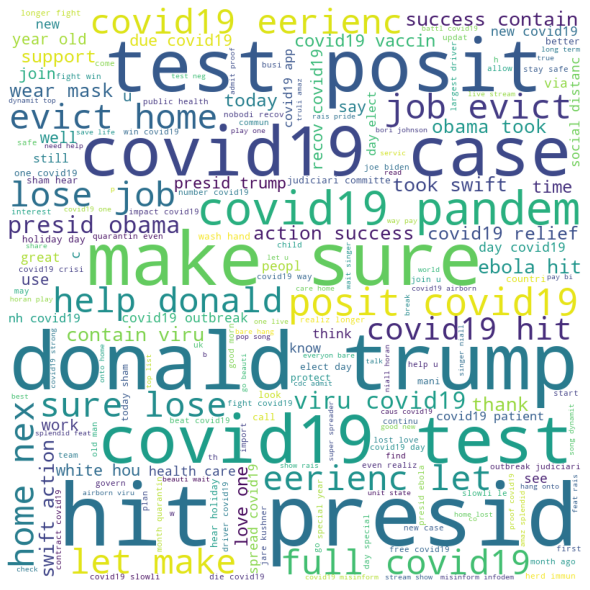

In [37]:
DataExploration.generate_word_cloud(pos_tweet)

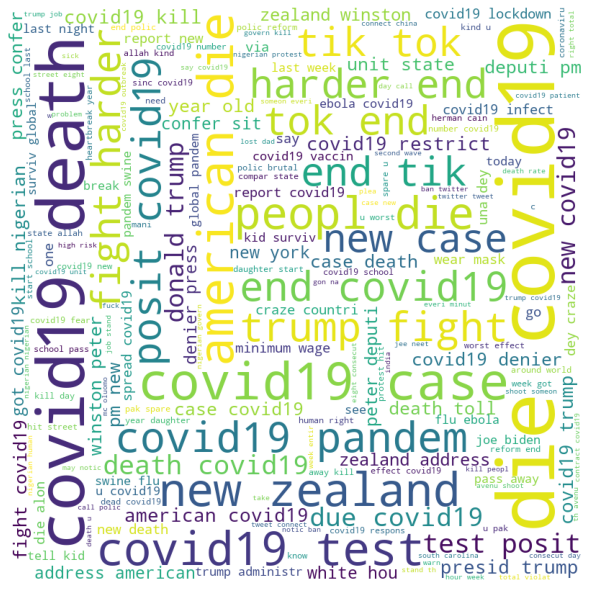

In [39]:
DataExploration.generate_word_cloud(neg_tweet)

## LDA

In [45]:
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(pos_tweet, num_topics = no_topics)
# lda_top30bow, bow_corpus, dictionary  = lda.fit_lda(pos_tweet, top_n_tokens = 30, num_topics = no_topics)
lda.lda_topics(lda_allbow)

,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,care,love,home,take,live,one,bare,thank,stay,new
1,2,presid,like,one,way,hit,success,never,hear,judiciari,contain
2,3,hous,rais,offer,white,top,k,told,soon,play,bring
3,4,test,share,trump,peopl,safe,plan,keep,india,great,like
4,5,test,mask,posit,need,wear,help,quarantin,thank,u,follow
5,6,pandem,like,help,nation,committe,everyon,play,support,top,fund
6,7,help,make,home,job,sure,donald,full,senat,month,nex
7,8,trump,year,get,win,let,old,even,vote,le,longer
8,9,trump,say,presid,million,new,case,took,elect,number,good
9,10,case,number,day,new,health,hand,outbreak,infect,holiday,public


In [46]:
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(neg_tweet, num_topics = no_topics)
# lda_top30bow, bow_corpus, dictionary  = lda.fit_lda(neg_tweet, top_n_tokens = 30, num_topics = no_topics)
lda.lda_topics(lda_allbow)

,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,may,sit,test,tr,protest,ban,campaign,bar,posit,break
1,2,trump,donald,fail,respons,biden,presid,joe,kid,recent,reform
2,3,die,said,busi,ad,owner,fought,practic,alon,american,biden
3,4,trump,fight,end,secur,dead,pay,nurs,say,home,elit
4,5,new,death,case,report,sinc,zealand,die,lockdown,began,countri
5,6,nigerian,kill,govern,american,right,human,violat,total,trump,peter
6,7,k,peopl,die,test,countri,dey,wage,una,minimum,craze
7,8,day,woman,protest,die,year,polic,white,high,kill,school
8,9,u,die,death,diseas,peopl,street,year,featur,eight,ill
9,10,flu,mask,pandem,stop,peopl,think,wear,tell,get,global
